# Data Cleaning and EDA for Neighborhood Economy Model
This notebook shows data cleaning process and EDA for a dataset I used in the neighborhood economy model. The main variables for the neighborhood economic forecasting model are Google mobility index from Google.com, small merchants revenue data from Economic Tracker, and COVID-19 new faily cases data. 

Contents:

1. Cleaning Google Mobility index data. 
2. Merging 1 and COVID-19 new daily case data to make a data set to be used in google mobility analysis. 
    - Handling missing values. 
    - Descriptive Statistics 
3. Cleaning small merchants revenue data. 
5. Merging 3 and COVID-19 new daily case data to make a data set to be used in merchents revenue analysis. 
    - Converting COVID-19 daily data to weekly data 
    - Merging 
    - Handling missing values.
    - Descriptive Statistics 
4. EDA 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Cleaning Google Mobility Index data.

Google release the mobility data on daily bases since the beginning of the COVID19 Google pandemic. The data approximates time spent away from home from cellphone location data by Google users. Data is indexed based on the 2019 mobility. Among dreakdown (Time Away From Home, Retail and Restaurants, Transit, Parks, Grocery, Workplace), I use Retail and Restaurants and Grocery as my variable to measure economic activity in neighborhood. 

Data can be downloaded from the Google Community Report. But for this project, I donwloaded from Economic Tracker web together with other economic data.  https://tracktherecovery.org/

In below, I read google mobility dataset, merge with Geo IDs dataset, and select counties in Washington DC metro area. 


In [2]:
# Read Google mobility data 
zip_file = ZipFile('EconomicTracker-main.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

google = dfs['EconomicTracker-main/data/Google Mobility - County - Daily.csv']

In [3]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751132 entries, 0 to 1751131
Data columns (total 11 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   year                       int64 
 1   month                      int64 
 2   day                        int64 
 3   countyfips                 int64 
 4   gps_retail_and_recreation  object
 5   gps_grocery_and_pharmacy   object
 6   gps_parks                  object
 7   gps_transit_stations       object
 8   gps_workplaces             object
 9   gps_residential            object
 10  gps_away_from_home         object
dtypes: int64(4), object(7)
memory usage: 147.0+ MB


Google mobility data has countyfips (county ID). I used this to merge with my GeoIDs data set and screen only washington DC area counties. 

In [4]:
# read geoID data
geo = pd.read_csv('Data/df_geo.csv')

# keep county and czname (metropolitan area name) 
geo_df = geo.loc[:, ['countyfips', 'countyname', 'czname', 'statename']]

# Merge wmply data and geoID data 
google_1 = google.merge(geo_df, on = 'countyfips', how='left')

# Keep counties belong to washington DC metro area 
googleDC = google_1[google_1.czname=='Washington DC']
googleDC.drop_duplicates(inplace=True)

googleDC.head()

,year,month,day,countyfips,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_parks,gps_transit_stations,gps_workplaces,gps_residential,gps_away_from_home,countyname,czname,statename
2044,2020,2,24,11001,-.0114,-.0329,.14,.00571,-.0143,.00714,-.00492,District Of Columbia,Washington DC,District Of Columbia
4470,2020,2,24,24009,.04,-.0243,.,.,.0214,-.00286,.0049,Calvert,Washington DC,Maryland
4495,2020,2,24,24017,.0214,.0214,.,.0807,.0143,-.00286,.00653,Charles,Washington DC,Maryland
4517,2020,2,24,24021,.0143,.0143,.24,.01,.0271,-.00571,.00952,Frederick,Washington DC,Maryland
4587,2020,2,24,24031,.00286,-.0329,.236,.00571,.0286,-.00143,.0025,Montgomery,Washington DC,Maryland


The purpose of this neighborhood economy model is to detect an economic activity across counties, so I use an average of 'retail and recreation' and grocery as my main time series data. To calcuate the average, first, I change the format to float, and then, calcuate the mean of retail and grocery. 


In [5]:
# replace '.' to missing 
googleDC['retail'] = googleDC.gps_retail_and_recreation.str.replace('.', '')
googleDC['grocery'] = googleDC.gps_grocery_and_pharmacy.str.replace('.', '')

# change the data type of google mobility data from object to float. 
googleDC['retail'] = pd.to_numeric(googleDC.retail,errors = 'coerce')
googleDC['grocery'] = pd.to_numeric(googleDC.grocery,errors = 'coerce')

# Create a new column which averages retail and recreation and grocery. 
googleDC['commercial'] = googleDC[['retail', 'grocery']].mean(axis=1)

Next, I create 'date' columns from year, month, day, and change it to a date time frame.  I also drop unnecessary columns. 'commercial' is my main target time series data. 

In [6]:
# create 'date' columns from year, month, and day_endofweek 
cols=["year","month","day"]
googleDC['date'] = googleDC[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

# set date into datetime frame
#googleDC.date = pd.to_datetime(googleDC.date)

# drop unnecessary columns 
drop_cols=['year', 'month', 'day', 'gps_retail_and_recreation',
       'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations', 
       'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'retail', 'grocery', 'czname', 'statename', 'countyname' ]
googleDC.drop(drop_cols, axis=1, inplace=True)

# drop duplicates
googleDC.drop_duplicates(inplace=True)

googleDC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11482 entries, 2044 to 7305299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countyfips  11482 non-null  int64  
 1   commercial  10973 non-null  float64
 2   date        11482 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 358.8+ KB


In below, I report the mean of commercial data by county IDs.  

In [7]:
googleDC.groupby('countyfips').mean()

,commercial
countyfips,
11001,-279.553237
24009,-103.010511
24017,-293.741007
24021,-129.422302
24031,-144.581295
24033,-340.058273
24037,-121.588489
51013,-309.799281
51059,-195.178417


I noticed that county ID'51157' has no values, so I dropped it. 

In [8]:
# Drop county'51157' because all are NaN
googleDC = googleDC[googleDC.countyfips!=51157]

# 2. Merging 1 and COVID-19 new daily case data to make a data set to be used in google mobility analysis.

### Cleaning COVID-19 new case data

SARIMAX model for google mobility analysis uses COVID-19 new cases as exogenous variable. People's mobility was clearly affected by the spread of COVID19 cases in 2020-2021. The data was downloaded from Economic Tracker web (https://tracktherecovery.org/) with other variabels. The data is originally from New York Times COVID tracker dataset. 

In below, I read data, create date column using year, month, day. And then, I merge this covid data to GeoIDs data to find out which counties belong to Washington DC metro area.  

In [9]:
# Read COVID-19 new daily case data 
covid = pd.read_csv('Data/COVID - County - Daily.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False)

# keep only daily new cases data  
covid = covid[['year', 'month', 'day', 'countyfips', 'new_case_count']]

# create date columns from year, month, day 
cols=["year","month","day"]
covid['date'] = covid[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")


# read geoID data
geo = pd.read_csv('Data/df_geo.csv')

# keep county and czname (metropolitan name) 
geo_df = geo.loc[:, ['countyfips', 'countyname', 'czname', 'statename']]

# Merge covid data and geoID data 
covid1 = covid.merge(geo_df, on = 'countyfips', how='left')

# Keep counties belong to washington DC metro area 
covidDC = covid1[covid1.czname=='Washington DC']
covidDC.drop_duplicates(inplace=True)

covidDC.head()


,year,month,day,countyfips,new_case_count,date,countyname,czname,statename
2100,2020,1,21,11001,.,2020-1-21,District Of Columbia,Washington DC,District Of Columbia
4640,2020,1,21,24009,.,2020-1-21,Calvert,Washington DC,Maryland
4665,2020,1,21,24017,.,2020-1-21,Charles,Washington DC,Maryland
4687,2020,1,21,24021,.,2020-1-21,Frederick,Washington DC,Maryland
4757,2020,1,21,24031,.,2020-1-21,Montgomery,Washington DC,Maryland


'new_case_count' has lots of '.' until 2020 March as well as at the last date of this data set. When I look at each zip code, new_cas_count starts appearing from second week of March. So, it is reasonable to replace '.' to 0 until March 2020. For the missing value in the last date ('2022-1-10'), I drop the row from this dataset. 

In [10]:
# Drop last date
index_drop = covidDC[covidDC.date == '2022-1-10'].index
covidDC.drop(index_drop, inplace = True)

# Replace . to 0 in new_case_count 
covidDC.loc[covidDC.new_case_count =='.', 'new_case_count']=0

# change new_case_count from object to integer
covidDC.new_case_count = covidDC.new_case_count.astype('int')

### Merge COVID data and Google mobility data, and handling missing values
I merge google mobility and covid19 data and name df. 

In [11]:
df = googleDC.merge(covidDC, on=['countyfips', 'date'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11080 entries, 0 to 11079
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   countyfips      11080 non-null  int64  
 1   commercial      10973 non-null  float64
 2   date            11080 non-null  object 
 3   year            10936 non-null  float64
 4   month           10936 non-null  float64
 5   day             10936 non-null  float64
 6   new_case_count  10936 non-null  float64
 7   countyname      10936 non-null  object 
 8   czname          10936 non-null  object 
 9   statename       10936 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 952.2+ KB


Set date and countyfips(county ID) as index. 

In [12]:
# set date into datetime frame
df.date = pd.to_datetime(df.date)


# set date and countyfips as index 
df = df.set_index(['countyfips', 'date']).sort_index() 


Because google data is available up to Jan 18, 2022 and COVID-19 is up to Jan 9th, 2022, I drop data after Jan 10th.  
For 'commercial', which is the averaged indicator of google mobility in retail and grocery stores, I use interpolation to fill the misisng values. 

In [13]:
# drop data after 2022-01-10 
df = df[df.index.get_level_values(1)<'2022-01-10']

# using interpolate() to fill the missing values 

df['commercial'] = df['commercial'].interpolate()

df.isnull().sum()

commercial        0
year              0
month             0
day               0
new_case_count    0
countyname        0
czname            0
statename         0
dtype: int64

### Report Descriptive Statistics for Google Mobility Index

In [14]:
# Coverage time periods 
firstday = df.index.get_level_values(1)[0]
lastday = df.index.get_level_values(1)[-1]
ndays =  df.index.get_level_values(1).nunique()

print(f'This data frame covers from {firstday} to {lastday}, in total {ndays} days. ')

This data frame covers from 2020-02-24 00:00:00 to 2022-01-09 00:00:00, in total 686 days. 


In [15]:
# Number of counties 
ncounty =  df.index.get_level_values(0).nunique()
print(f'The data includes {ncounty} counties in Washington DC metro area. ')


The data includes 16 counties in Washington DC metro area. 


Next I report the statistics. 

In [16]:
df.describe()

,commercial,year,month,day,new_case_count
count,10936.000000,10936.000000,10936.000000,10936.000000,10936.000000
mean,-173.823427,2020.560351,6.842813,15.704462,70.468910
std,268.918419,0.522224,3.307787,8.862620,192.849618
min,-986.000000,2020.000000,1.000000,1.000000,0.000000
25%,-341.000000,2020.000000,4.000000,8.000000,6.000000
50%,-197.000000,2021.000000,7.000000,16.000000,22.000000
75%,-56.500000,2021.000000,10.000000,23.000000,73.000000
max,964.500000,2022.000000,12.000000,31.000000,4256.000000


Commercial time-series data (google mobility index in the commercial area) are mostly negative. This makes sense because this indicator measures a change in people's mobility from the previous year. During the pandemic, people's mobility was dropped in commercial places. Positive numbers were from reopening time in 2021.
Daily new cases vary from zero to 4256.

Save the google mobility data set for modeling. 

In [17]:
# Drop unnecessary columns for modeling 
cols = ['year', 'month', 'day', 'czname', 'statename', 'countyname' ]
df.drop(cols, axis=1, inplace=True)

# reset index
df.reset_index(inplace=True)
# Save
df.to_csv('Data/mobility.csv', index=False)

# 3. Cleaning small merchants revenue data.


Small merchants revenue data was downloaded from Economic Tracker web (https://tracktherecovery.org/) with other variabels. The data is originally from Womply. The data is originally from Womply. This data reports number of small merchants openings and revenue changes for each county every week from January 2020. Since my focus is DC metro area, I drop counties outside of the DC metro area. I use GeoIDs data to filter counties in the DC metro region.

In [18]:
zip_file = ZipFile('EconomicTracker-main.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

Womply = dfs['EconomicTracker-main/data/Womply - County - Weekly.csv']
Womply.tail()

,year,month,day_endofweek,countyfips,revenue_all,merchants_all
102404,2021,1,30,55133,-0.0585,-0.159
102405,2021,1,30,55135,-0.0327,-0.186
102406,2021,1,30,55137,-0.2860,-0.283
102407,2021,1,30,55139,-0.3310,-0.090
102408,2021,1,30,55141,-0.1690,-0.265


Read GeoIDs data and merge it to small merchants data. 

In [19]:
# read geoID data
geo = pd.read_csv('Data/df_geo.csv')

# keep county and czname (metropolitan name) 
geo_df = geo.loc[:, ['countyfips', 'countyname', 'czname', 'statename']]

# Merge wmply data and geoID data 
Womply1 = Womply.merge(geo_df, on = 'countyfips', how='left')

# Keep counties belong to washington DC metro area 
WomDC = Womply1[Womply1.czname=='Washington DC']
WomDC.drop_duplicates(inplace=True)

WomDC.head()

,year,month,day_endofweek,countyfips,revenue_all,merchants_all,countyname,czname,statename
1966,2020,1,11,11001,0.0302,-0.0357,District Of Columbia,Washington DC,District Of Columbia
4027,2020,1,11,24009,0.0136,0.0023,Calvert,Washington DC,Maryland
4052,2020,1,11,24017,0.0810,-0.0238,Charles,Washington DC,Maryland
4074,2020,1,11,24021,-0.0298,-0.0241,Frederick,Washington DC,Maryland
4144,2020,1,11,24031,-0.0524,-0.0419,Montgomery,Washington DC,Maryland


Next, I create 'date' columns and set date into datetime frame. 

In [20]:
# create 'date' columns from year, month, and day_endofweek 
cols=["year","month","day_endofweek"]
WomDC['date'] = WomDC[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

# set date into datetime frame
WomDC.date = pd.to_datetime(WomDC.date)


# drop duplicates
WomDC.drop_duplicates(inplace=True)

WomDC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 1966 to 521048
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   year           864 non-null    int64         
 1   month          864 non-null    int64         
 2   day_endofweek  864 non-null    int64         
 3   countyfips     864 non-null    int64         
 4   revenue_all    864 non-null    float64       
 5   merchants_all  864 non-null    float64       
 6   countyname     864 non-null    object        
 7   czname         864 non-null    object        
 8   statename      864 non-null    object        
 9   date           864 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 74.2+ KB


### Read COVID data to merge with small merchants revenue data

I want daily new covid cases for developing a model, so I keep only 'new_case_count'. And I create date column using year, month, day. And then, I merge this covid data to geoID data to find out which counties belong to washington DC metro area.  

In [21]:
# Read data 
covid = pd.read_csv('Data/COVID - County - Daily.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False)

# keep only daily new cases data  
covid = covid[['year', 'month', 'day', 'countyfips', 'new_case_count']]

# create date columns from year, month, day 
cols=["year","month","day"]
covid['date'] = covid[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")


# read geoID data
geo = pd.read_csv('Data/df_geo.csv')

# keep county and czname (metropolitan name) 
geo_df = geo.loc[:, ['countyfips', 'countyname', 'czname', 'statename']]

# Merge covid data and geoID data 
covid1 = covid.merge(geo_df, on = 'countyfips', how='left')

# Keep counties belong to washington DC metro area 
covidDC = covid1[covid1.czname=='Washington DC']
covidDC.drop_duplicates(inplace=True)

covidDC.head()


,year,month,day,countyfips,new_case_count,date,countyname,czname,statename
2100,2020,1,21,11001,.,2020-1-21,District Of Columbia,Washington DC,District Of Columbia
4640,2020,1,21,24009,.,2020-1-21,Calvert,Washington DC,Maryland
4665,2020,1,21,24017,.,2020-1-21,Charles,Washington DC,Maryland
4687,2020,1,21,24021,.,2020-1-21,Frederick,Washington DC,Maryland
4757,2020,1,21,24031,.,2020-1-21,Montgomery,Washington DC,Maryland


'new_case_count' has lots of '.' until 2020 March as well as at the last date of this data set. If I take a look each zip code, new_cas_count starts appearing from second week of March. So, it is safe to replace '.' to 0 until March 2020. For the missing value in thelast date ('2022-1-10'), I drop the row from this dataset. 

In [22]:
# Drop last date
index_drop = covidDC[covidDC.date == '2022-1-10'].index
covidDC.drop(index_drop, inplace = True)

# Replace . to 0 in new_case_count 
covidDC.loc[covidDC.new_case_count =='.', 'new_case_count']=0

# change new_case_count from object to integer
covidDC.new_case_count = covidDC.new_case_count.astype('int')

# 4. Merging 3 and COVID-19 new daily case data to make a data set to be used in merchents revenue analysis.


### Converting COVID-19 daily data to weekly data

To merge with small merchants data, I need to convert the daily new case data to weekly data. Below, I change the data to time series and then convert it to weekly data by using resampling method.

In [23]:
# set date into datetime frame
covidDC.date = pd.to_datetime(covidDC.date)


# set date and countyfips as index 
covidDC = covidDC.set_index(['countyfips', 'date']).sort_index() 



Next, I resample the time series to weekly data. To resample all counties with a for loop, I store each downsampled data frame in a list and then change it back to the data frame. 

In [24]:
# To store the dataframe 
downsample = [] 
fips = []

# Resample for all counties and store the data frame in a list  
county = list(covidDC.index.get_level_values(0).unique())
for x in county:
    # To match the small merchants data, I set W-Sat as the aggregation cycle. 
    weekly = covidDC.loc[(x, ),]['new_case_count'].resample('W-SAT').mean()
    wk = pd.DataFrame(weekly, columns=['new_case_count'])
    downsample.append(wk)
    fips.append(x)

# Zip downsample and county IDs and save in a new list. 
downsample_df = []
for df, county in zip(downsample, fips):
    df['countyfips']=county
    downsample_df.append(df)

# merge all data frame in a list and save as covid_weekly
covid_weekly = pd.concat(downsample_df)

# reset index
covid_weekly.reset_index(inplace=True)

covid_weekly.head()

,date,new_case_count,countyfips
0,2020-01-25,0.0,11001
1,2020-02-01,0.0,11001
2,2020-02-08,0.0,11001
3,2020-02-15,0.0,11001
4,2020-02-22,0.0,11001


Save covid weekly data for later analysis.  

In [25]:
covid_weekly.to_csv('Data/covid_weekly.csv', index=False)

### Merging small merchants data and weekly COVID-19 new case data

Finally, I merge small merchants data and weekly covid-19 data. 

In [26]:
# Merge merchant data and weekly covid case data 
dfm = WomDC.merge(covid_weekly, on=['countyfips', 'date'], how='left')
dfm.head()

,year,month,day_endofweek,countyfips,revenue_all,merchants_all,countyname,czname,statename,date,new_case_count
0,2020,1,11,11001,0.0302,-0.0357,District Of Columbia,Washington DC,District Of Columbia,2020-01-11,NaN
1,2020,1,11,24009,0.0136,0.0023,Calvert,Washington DC,Maryland,2020-01-11,NaN
2,2020,1,11,24017,0.0810,-0.0238,Charles,Washington DC,Maryland,2020-01-11,NaN
3,2020,1,11,24021,-0.0298,-0.0241,Frederick,Washington DC,Maryland,2020-01-11,NaN
4,2020,1,11,24031,-0.0524,-0.0419,Montgomery,Washington DC,Maryland,2020-01-11,NaN


Create 'yearmonth' data for later analysis, and drop unnecessary columns.  

In [27]:
dfm

,year,month,day_endofweek,countyfips,revenue_all,merchants_all,countyname,czname,statename,date,new_case_count
0,2020,1,11,11001,0.0302,-0.0357,District Of Columbia,Washington DC,District Of Columbia,2020-01-11,NaN
1,2020,1,11,24009,0.0136,0.0023,Calvert,Washington DC,Maryland,2020-01-11,NaN
2,2020,1,11,24017,0.0810,-0.0238,Charles,Washington DC,Maryland,2020-01-11,NaN
3,2020,1,11,24021,-0.0298,-0.0241,Frederick,Washington DC,Maryland,2020-01-11,NaN
4,2020,1,11,24031,-0.0524,-0.0419,Montgomery,Washington DC,Maryland,2020-01-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...
859,2021,1,30,51153,-0.4510,-0.3260,Prince William,Washington DC,Virginia,2021-01-30,269.428571
860,2021,1,30,51187,-0.5060,-0.2220,Warren,Washington DC,Virginia,2021-01-30,21.714286
861,2021,1,30,51510,-0.4520,-0.3940,Alexandria City,Washington DC,Virginia,2021-01-30,55.000000
862,2021,1,30,51610,-0.4640,-0.3480,Falls Church City,Washington DC,Virginia,2021-01-30,4.857143


In [28]:
dfm['yearmonth']=dfm.year*100 + dfm.month
# drop unnecessary columns 
cols = ['year', 'month', 'day_endofweek', 'countyname', 'czname', 'statename', ] 
dfm.drop(cols, axis=1, inplace=True)

Set date and countyfips (county ID) as index, and then report missing vaues. 

In [29]:
# set date into datetime frame
dfm.date = pd.to_datetime(dfm.date)


# set date and countyfips as index 
dfm = dfm.set_index(['countyfips', 'date']).sort_index() 

# report missing values 
dfm.isnull().sum()

revenue_all        0
merchants_all      0
new_case_count    32
yearmonth          0
dtype: int64

'new_case_count' has lots of missing values until 2020 March. When I take a look at each county, new_cas_count starts appearing from the second week of March. So, it is safe to replace missing to 0 until March 2020.

In [30]:
# Replace . to 0 in new_case_count 
dfm['new_case_count'].fillna(0, inplace=True)

dfm.isnull().sum()

revenue_all       0
merchants_all     0
new_case_count    0
yearmonth         0
dtype: int64

### Save small merchant data for modeling. 
Now I created the small merchant data set. I save this data frame for modeling.  

In [31]:

# Save
dfm.to_csv('Data/small_business.csv', index=True)


### Descriptive Statistics of Small Merchants Data

In [32]:
# Time periods 
firstday = dfm.index.get_level_values(1)[0]
lastday = dfm.index.get_level_values(1)[-1]
ndays =  dfm.index.get_level_values(1).nunique()

print(f'This data frame covers from {firstday} to {lastday}, in total {ndays} days. ')

This data frame covers from 2020-01-11 00:00:00 to 2021-01-30 00:00:00, in total 54 days. 


In [33]:
# Number of counties 
ncounty =  dfm.index.get_level_values(0).nunique()
print(f'The data includes {ncounty} counties in Washington DC metro area. ')


The data includes 16 counties in Washington DC metro area. 


In [34]:
dfm.describe()

,revenue_all,merchants_all,new_case_count,yearmonth
count,864.000000,864.000000,864.000000,864.000000
mean,-0.305464,-0.250530,49.363426,202011.833333
std,0.192140,0.144116,87.525534,21.884983
min,-0.799000,-0.555000,0.000000,202001.000000
25%,-0.441000,-0.347000,1.250000,202004.000000
50%,-0.310000,-0.281000,14.142857,202007.000000
75%,-0.191000,-0.165750,56.607143,202010.000000
max,0.376000,0.141000,630.285714,202101.000000


Revenue changes (revenue_all) varies from -0.79 to 0.37. The majority of the data points are negative as most small stores are fragile against economic shocks during the pandemic. 

In [35]:
dfm.groupby('yearmonth').mean()

,revenue_all,merchants_all,new_case_count
yearmonth,,,
202001,-0.012023,-0.004316,0.000000
202002,-0.048342,-0.014408,0.000000
202003,-0.271706,-0.165834,1.526786
202004,-0.494187,-0.416359,35.468750
202005,-0.421890,-0.355135,77.269643
202006,-0.307622,-0.279508,42.707589
202007,-0.291997,-0.234644,27.437500
202008,-0.343561,-0.276164,35.392857
202009,-0.336598,-0.278395,32.241071


Revenue data dropped sharply on 2020March due to the economic lockdown. 
   

# 5. EDA for Washington DC county

In this EDA, I focus on Washington DC county to see the patterns of google mobility, small merchants revenue changes, and COVID-19 cases.

### Google mobility index

First, I examine Google Mobility Index. In below, I read the google mobility data from 'Data/mobility.csv', which I created in the section 1 of this notebook. And I set date and county ID as Index 

In [36]:
# read google mobility data frame
df = pd.read_csv('Data/mobility.csv')

# Set date and county ID as index. 

df = df.set_index(['countyfips', 'date']).sort_index() 


To check seasonality and trend of google mobility index, I plot the time series in below. 

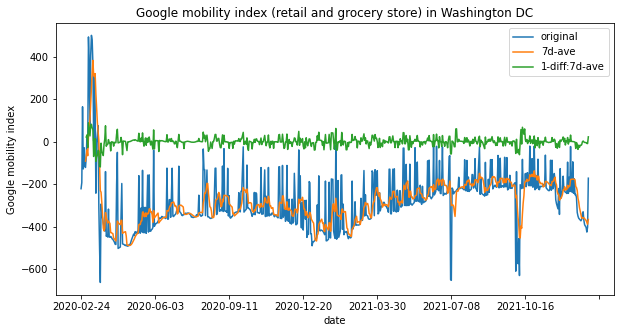

In [37]:
#commercial = df.loc[(11001, ),]['commercial'].plot()
df.loc[(11001, ),]['commercial'].plot(figsize=(10, 8), label='original')
df.loc[(11001, ),]['commercial'].rolling(7).mean().plot( label ='7d-ave', figsize=(10,5))
df.loc[(11001, ),]['commercial'].diff().rolling(7).mean().plot( label = '1-diff:7d-ave')

plt.ylabel('Google mobility index')
plt.title('Google mobility index (retail and grocery store) in Washington DC')
plt.legend();

Google mobility index clearly shows some seasonal trends. Mobility is higher during the weekend, and also mobility is lower during the winter. In terms of trend, there was a considerable drop in March 2020, when the US declared a national emergency, and all states followed. Other steep drops in July and October in 2021 and January 2022 correspond to multiple waves of COVID-19 surges due to the new variant. After taking one difference, the time series looks stationary.

Next, I use seasonal decomposition to detect seasonality, trend, and any noise in the dataset. I set period=7 because this is the daily data. 

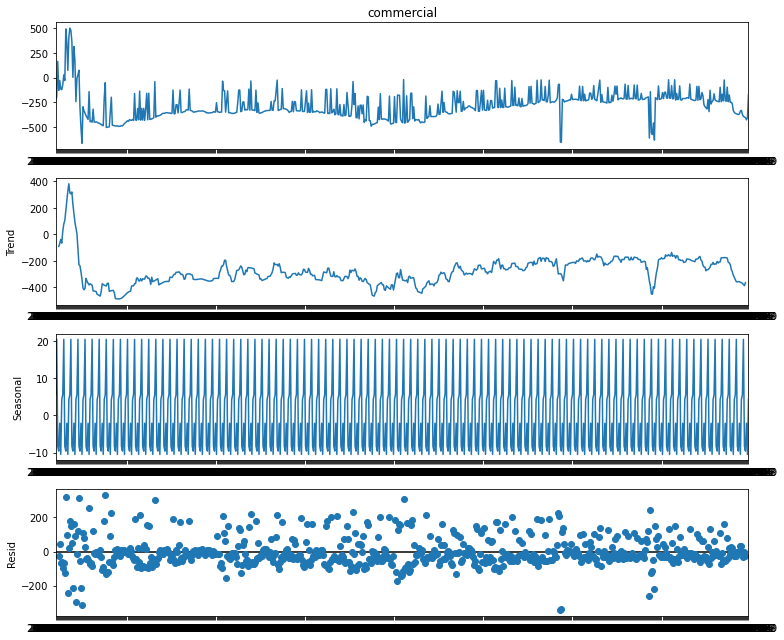

In [38]:
rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(df.loc[(11001, ),]['commercial'], model='additive', period=7)
fig = decomposition.plot();

The decomposition figures show weekly seasonality and a sharp drop in march 2020 and additional drops in 2021 Fall and 2022 January.

### COVID-19 daily new cases

Next, I plot the COVID-19 new cases in Washington DC county. 

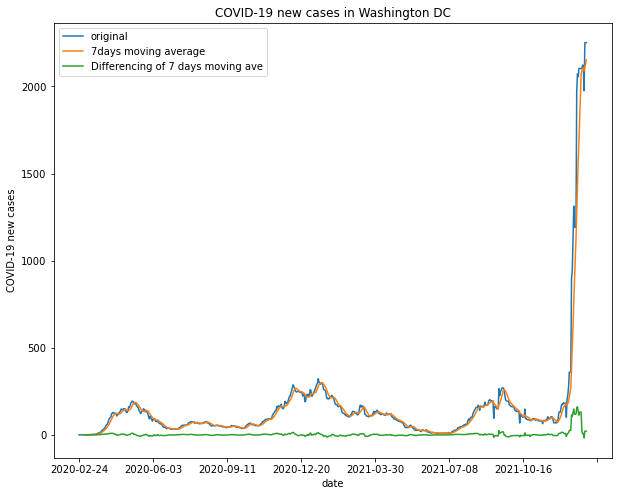

In [39]:
# plot covid cases 
df.loc[(11001, ),]['new_case_count'].plot(figsize=(10, 8), label='original')
df.loc[(11001, ),]['new_case_count'].rolling(7).mean().plot( label ='7days moving average')
df.loc[(11001, ),]['new_case_count'].diff().rolling(7).mean().plot( label = 'Differencing of 7 days moving ave')

plt.ylabel('COVID-19 new cases')
plt.title('COVID-19 new cases in Washington DC')
plt.legend();

The figrue shows the multiple waves of COVID-19 surges on May 2020, January 2021, Octover 2022, and Januaey 2022.  
The time series turned to be stational one I take first difference of 7 days moving average.  

Next, I use seasonal decomposition to detect seasonality, trend, and any noise in the time series. I set period=7 because this is the daily data.

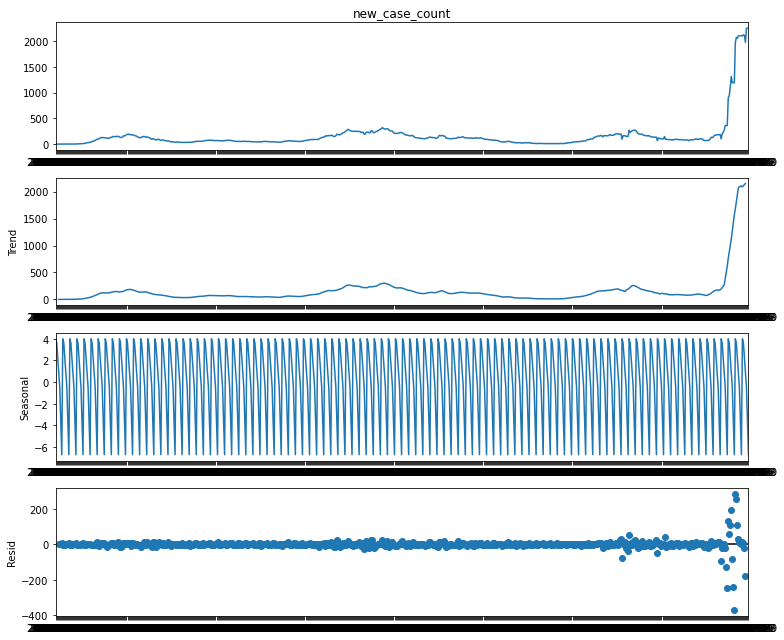

In [40]:

rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(df.loc[(11001, ),]['new_case_count'], model='additive', period=7)
fig = decomposition.plot();

The seasonal decomposition tells that there is a weekly seasonality. This is because more people go to a test center after the weekend. In terms of trend, there is a huge jump from Dec 2021 to Jan 2022 .  

The trend of google mobility is negatively correlated with COVID-19 new cases. As the COVID-19 surges, people stop going out to commercial places. And once the virus slowed, people start going out again. Mobility also will cause the COVID-19 waves. This is especially true when COVID-19 starts surging. The place with more people in restaurants and stores tends to report higher COVID-19 spread. However, the higher mobility itself may not cause the COVID-19 surge. And there are many times when mobility is higher, but there is no rise in new cases. So, I will treat COVID-19 new cases as exogenous variables, therefore, SARIMAX model is the best fit for the Google mobility index forecast.


### Small Merchants Revenue Changes 

Next, I explore small merchants revenue data. First, I read the small merchents data set I created in section 3 of this notebook, and set date and county ID as index. 

In [41]:
df = pd.read_csv('Data/small_business.csv')


# Set date and county ID as index. 
df = df.set_index(['countyfips', 'date']).sort_index() 

Below, I plot the small merchant's revenues in Washington DC county. 

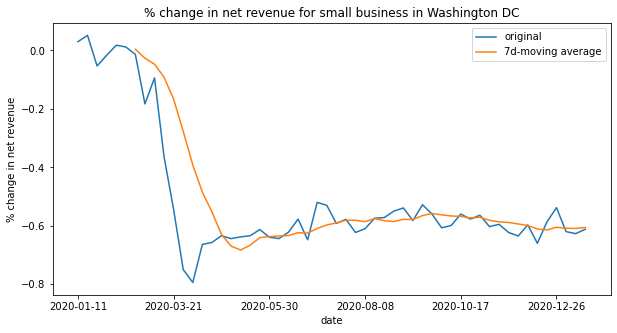

In [42]:
#commercial = df.loc[(11001, ),]['commercial'].plot()
df.loc[(11001, ),]['revenue_all'].plot(figsize=(10, 8), label='original')
df.loc[(11001, ),]['revenue_all'].rolling(7).mean().plot( label ='7d-moving average', figsize=(10,5))

plt.ylabel('% change in net revenue')
plt.title('% change in net revenue for small business in Washington DC')
plt.legend();

Revenue sharply dropped on march 2020. Other than this large drop, the time series looks stationary.     

Next, I use seasonal decomposition to detect seasonality, trend and any noise in the dataset.

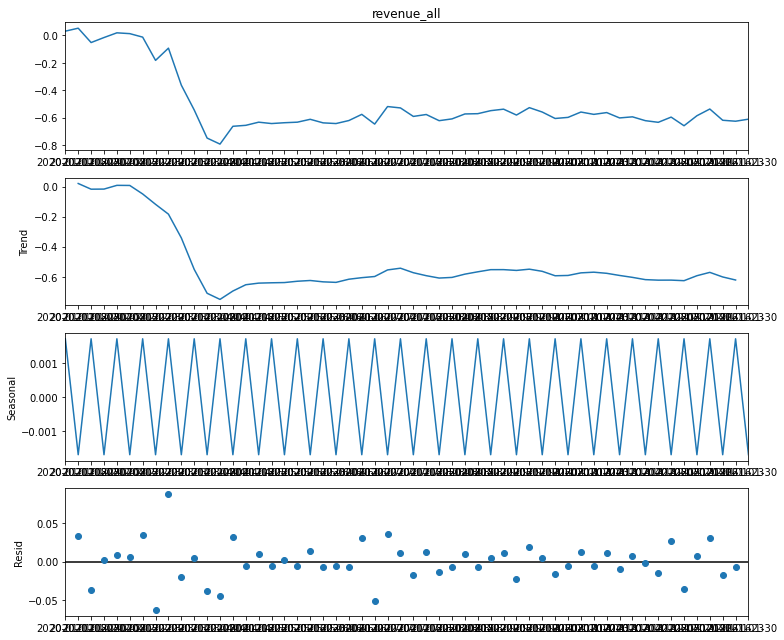

In [43]:

rcParams['figure.figsize'] = 11, 9
x = df.loc[(11001, ),]['revenue_all']
decomposition = seasonal_decompose(x, model='additive', period=2)
fig = decomposition.plot();

Revenue sharply dropped on march 2020 and stagnant for the rest of the time period. I see some seasonality trends in every two weeks cycle. 
